# Lab 1. Plotting WSR-88D data in Py-ART
Today, we'll use a nice Python package called Py-ART to plot some WSR-88D observations.

You can read more about Py-ART's capabilities here.
https://arm-doe.github.io/pyart/

Make sure you are using your "eaps523-2022" kernel. If not, switch to it before running this notebook.

Pull down the Kernel menu, and select "Change Kernel" -> "Python (My eaps523-2022 kernel)"

## First, a tiny bit of practice for those who have never used a Jupyter Notebook before. 
Jupyter Notebooks allow you to work interactively with Python. A notebook will usually consist of Python <B>code</B> cells (colored gray) interspersed with explanatory text (called <B>Markdown</B> cells, like this one you're reading).

# To execute a code cell, place your cursor in it, and press Shift+Enter.

In [1]:
1+1

2

You'll notice that "In [1]:" now appears to the left of the code block. 

The output (2) now appears below it, beside a corresponding "Out [1]:" block.

If you see an asterisk (\*) instead of a number after executing a block (e.g., "In [\*]:"), that means that the block is in the process of executing. Some blocks may take several seconds or minutes, depending on how computationally heavy they are.

Some Python commands might not produce output, or may produce different kinds of output (like graphics).

# A basic code cell to plot something might look like this:

Note that we alias the module <B>matplotlib.pyplot</B> to the shorter name <B>plt</B>, so that we don't have to type <B>matplotlib.pyplot</B> over and over again.

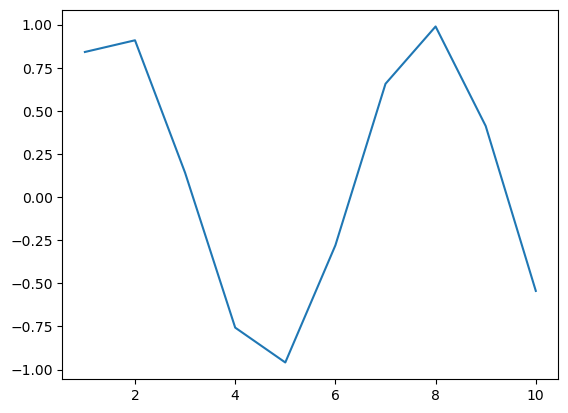

In [2]:
# Import a popular plotting library, Matplotlib:
from matplotlib import pyplot as plt
# Import a popular numerical library, NumPy:
import numpy as np

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # A list of numbers.
y = np.sin(x) # Calculate the sine of all these numbers.
# Plot the result:
plt.plot(x, y)

You should see a chunky sine wave. If not, raise your hand and ask for assistance.

# Now, let's warp ahead and plot some radar data.
## First, we'll import a truckload of necessary libraries. 

In [20]:
import pyart
import os
import sys
from glob import glob
import platform
import copy
import netCDF4
import datetime
import numpy as np
from matplotlib import pyplot as plt
#from boto3.s3.connection import S3Connection
import boto3
import cartopy.crs as ccrs
import tempfile
# Suppress most (but not all) warnings
import warnings
warnings.simplefilter('ignore') 




import boto3
from botocore.handlers import disable_signing


# using shapefile


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt


# reader = shpreader.Reader('./texas_state.shp')
# counties = list(reader.geometries())
# COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())



import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from metpy.plots import USCOUNTIES
import tqdm
# import nexradaws
# import pytz


import botocore


# Magic command that forces all graphical output to appear in this notebook.
%matplotlib inline

In [23]:

# session = boto3.Session(
#     aws_access_key_id=settings.AWS_SERVER_PUBLIC_KEY,
#     aws_secret_access_key=settings.AWS_SERVER_SECRET_KEY,
# )

## Next, we need to define two functions for grabbing the WSR-88D data off the Amazon web server. 
The first, _nearestDate, finds the closest item in a list.

The second, get_radar_from_aws, does exactly what it sounds like it should.

Note that I stole this chunk of code from Dr. Scott Collis:
https://github.com/scollis/notebooks/blob/master/Irma.ipynb

In [35]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))




# "KMUX" "march 12 - 15 2023" "selinas california" "atmospheric river, dumped a bunch of water, flooding", "poverty ridden area" 

def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    https://boto3.amazonaws.com/v1/documentation/api/latest/guide/migrations3.html
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    
    s3_resource = boto3.resource('s3')
    s3_resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)


    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    
    # populate the list
    buc = s3_resource.Bucket("noaa-nexrad-level2")
    for bucket in buc.objects.filter(Prefix=my_pref):
        this_str = str(bucket.key)
        #print(f" {this_str}")
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket)

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket)

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    
    localfile = "./bucket_out.out"
    with open(localfile , 'wb') as data:
        obj = keys[index]
        obj.Object().download_fileobj(data)
    
    # print(keys[index])
    # .download_fileobj( keys[index], localfile)
    # keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile)
    return radar

In [36]:


def plot_radar_image(radar, radar_start_date):


    ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
    lats = radar.gate_latitude
    lons = radar.gate_longitude
    height = radar.gate_altitude
    lats = radar.gate_latitude
    lons = radar.gate_longitude
    min_lon = lons['data'].min()
    min_lat = lats['data'].min()
    max_lat = lats['data'].max()
    max_lon = lons['data'].max()
    
    lat_lines = np.arange(min_lat, max_lat, 1)
    lon_lines = np.arange(min_lon, max_lon, .1)



    
    # Setting projection and ploting the lowest tilt
    projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                       central_longitude=radar.longitude['data'][0])
    
    
    fig = plt.figure(figsize=(12, 10), dpi=150)
    fig.set_facecolor('white')
    
    # create axis using cartopy projections, add in coastlines & grid
    ax = fig.add_subplot(1,1,1,projection=projection )
    
    
    # tmp = ax.axis('off') # Turn off enclosing frame
    display = pyart.graph.RadarMapDisplay(radar)
    
    
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
    
    # ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    
    ax.add_feature(cfeature.STATES, linewidth=3)
    ax.add_feature(USCOUNTIES, alpha=0.4)
    
    
    # Setting projection and ploting the lowest tilt
    projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                       central_longitude=radar.longitude['data'][0])
    # Built-in Py-ART function to plot PPIs.
    
    
    
    
    # See: 
    display.plot_ppi_map('reflectivity', sweep = 0, vmin = 0, vmax = 50,
                         ax=ax,
                         min_lon = min_lon, max_lon = max_lon,
                         min_lat = min_lat, max_lat = max_lat,
                         resolution = '10m', projection = projection, fig = fig, cmap = "pyart_HomeyerRainbow")
    
    plt.savefig('./ref_'+ station+ '_' + ymd_string + hms_string + '.png')




## Let's grab a radar volume from somewhere.
The four-letter code is the call sign for the radar. 
A list of these sites can be found here:
https://www.roc.noaa.gov/WSR88D/Maps.aspx

In [ ]:
station = 'KHGX'
#station = 'KLCH'

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

start_date = datetime.datetime(2017, 8, 26, 1, 00)
end_date = datetime.datetime(2017, 8, 27, 1, 00)
# date_list = daterange(start_date, end_date)
# print(date_list)
# for single_date in tqdm.tqdm(date_list):
#     sin_date = single_date.strftime("%Y-%m-%d")
#     datetime.datetime.strptime(date, "%Y-%m-%d")

delta = datetime.timedelta(days=1)
current_date = start_date
while tqdm.tqdm(current_date <= end_date):
    current_date += delta
    print(f"{current_date}")
    radar = get_radar_from_aws(station, current_date)
    radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'], only_use_cftime_datetimes = False, only_use_python_datetimes = True)
    plot_radar_image(radar, radar_start_date)




    
# my_datetime = datetime.datetime(2017, 8, 26, 1, 00)
# radar = get_radar_from_aws(station, my_datetime)

In [18]:
radar

The block above should return a line containing the name of a WSR-88D data file, ending in "_V06." If it doesn't, the date you entered may be invalid. Check this.

# We have now created a Python Radar class object called "radar." 
It contains all the attributes and data associated with a radar data file. You can read more about this class here: http://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html

# Let's explore our radar object's contents. 

In [46]:
print(radar.fields.keys())
radar_start_date = netCDF4.num2date(radar.time['data'][0],
        radar.time['units'], only_use_cftime_datetimes = False, only_use_python_datetimes = True)
print("Radar Start Date:",radar_start_date)

dict_keys(['velocity', 'differential_reflectivity', 'cross_correlation_ratio', 'reflectivity', 'differential_phase', 'spectrum_width'])
Radar Start Date: 2017-08-26 01:02:40.788000


This returns a list of the fields inside the Radar object, corresponding to the variables in the file. Also note that the start time of the file is indeed very close to the time we requested.

Let's stash some of the file's contents in local variables for use when plotting.

In [47]:
ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
lats = radar.gate_latitude
lons = radar.gate_longitude
height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

lat_lines = np.arange(min_lat, max_lat, 1)
lon_lines = np.arange(min_lon, max_lon, .1)

In [49]:
# using shapefile


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt


# reader = shpreader.Reader('./texas_state.shp')
# counties = list(reader.geometries())
# COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())



import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from metpy.plots import USCOUNTIES
# import nexradaws
# import pytz



## Now, let's do some actual plotting.
We'll start by plotting reflectivity at the lowest tilt (sweep = 1, which corresponds to 0.5 degrees in elevation).

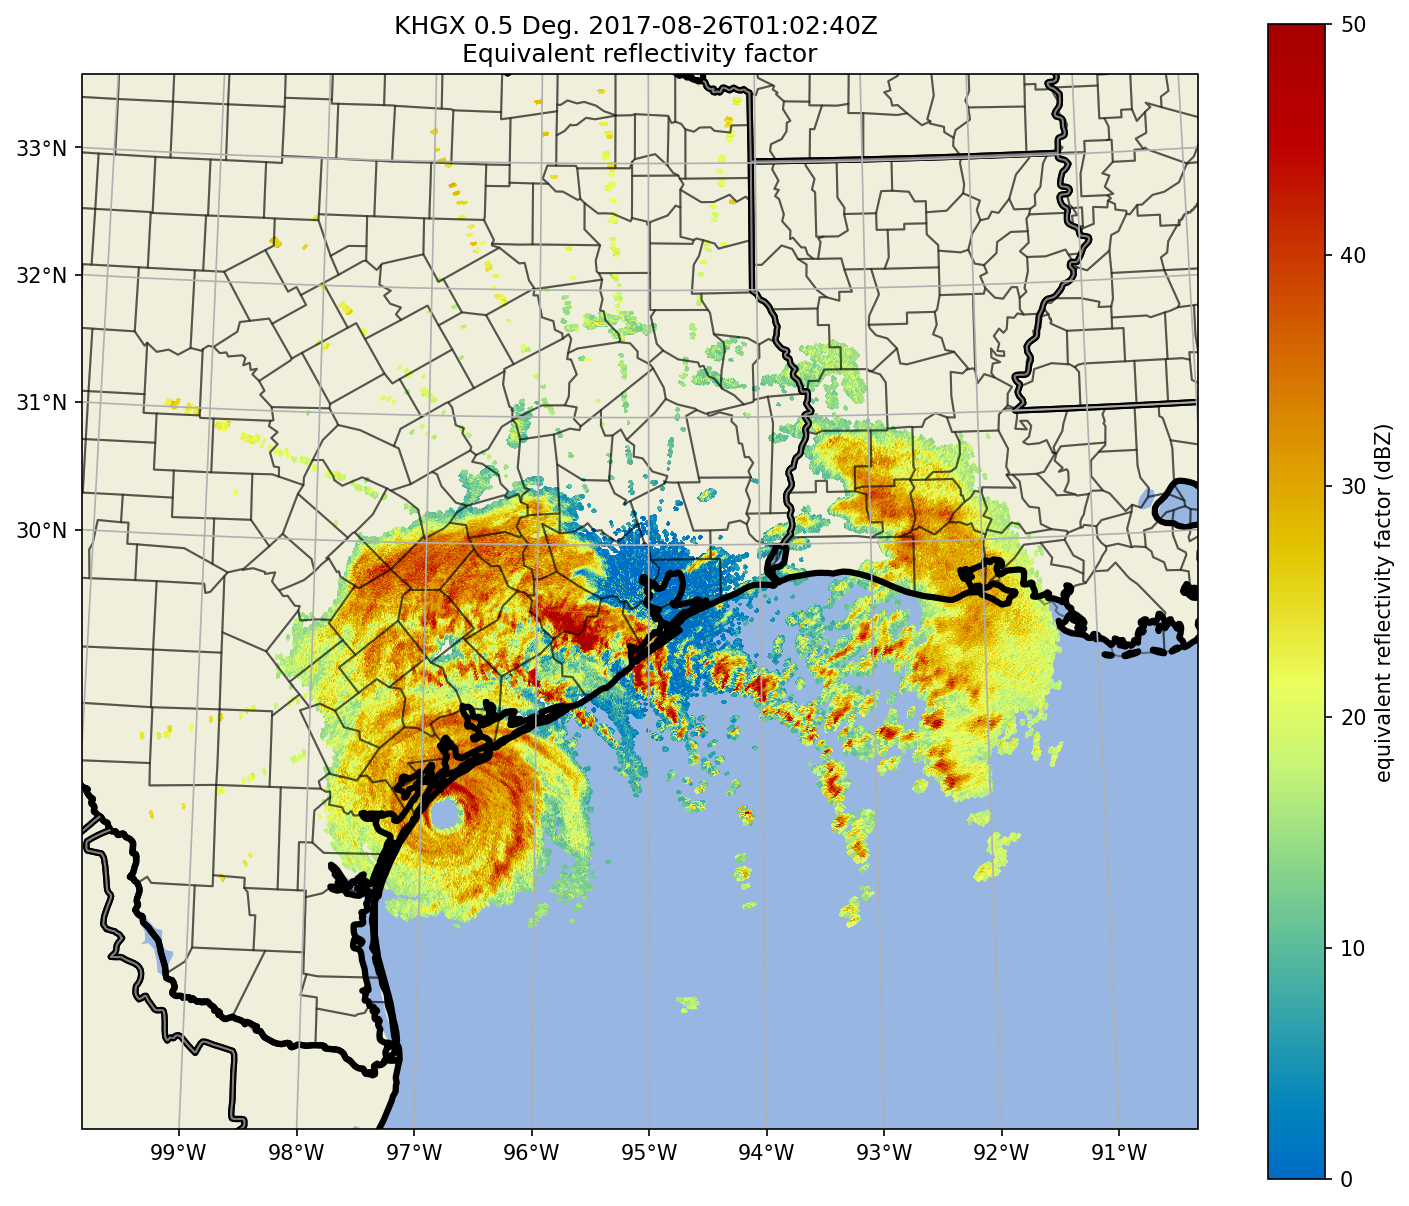

In [57]:

# Setting projection and ploting the lowest tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])


fig = plt.figure(figsize=(12, 10), dpi=150)
fig.set_facecolor('white')

# create axis using cartopy projections, add in coastlines & grid
ax = fig.add_subplot(1,1,1,projection=projection )


# tmp = ax.axis('off') # Turn off enclosing frame
display = pyart.graph.RadarMapDisplay(radar)


ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))

# ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

ax.add_feature(cfeature.STATES, linewidth=3)
ax.add_feature(USCOUNTIES, alpha=0.4)


# Setting projection and ploting the lowest tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])
# Built-in Py-ART function to plot PPIs.




# See: 
display.plot_ppi_map('reflectivity', sweep = 0, vmin = 0, vmax = 50,
                     ax=ax,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                     resolution = '10m', projection = projection, fig = fig, cmap = "pyart_HomeyerRainbow")

# Latitude and longitude of the marker
# marker_lat = 29.7604  # Replace with your desired latitude
# marker_lon = -95.3698  # Replace with your desired longitude


marker_lat = 27.8006  # Replace with your desired latitude
marker_lon = -97.3964  # Replace with your desired longitude

# Add a star marker at the specified latitude and longitude
#ax.plot(marker_lon, marker_lat, marker='*', markersize=30, color='k', zorder=22)


#plt.scatter(marker_lon, marker_lat, marker='.', s=60, color='k');
#plt.savefig('ref_'+station+'_'+ymd_string+hms_string+'.png')






marker_lat = 27.8006  # Replace with your desired latitude
marker_lon = -97.3964  # Replace with your desired longitude

# plt.scatter(marker_lon, marker_lat, marker='.', s=300, color='b');
plt.savefig('./ref_'+ station+ '_' + ymd_string + hms_string + '.png')

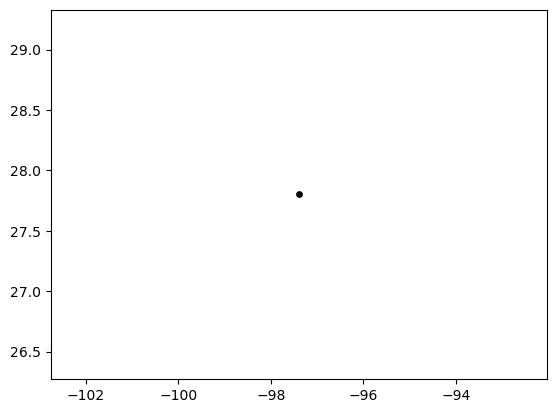

In [54]:


marker_lat = 27.8006  # Replace with your desired latitude
marker_lon = -97.3964  # Replace with your desired longitude

plt.scatter(marker_lon, marker_lat, marker='.', s=60, color='k');

Not bad for a first plot! Note that Py-ART has already populated the title, axes, and colorbar for you with variables from the Radar object. You will also find the image above has been saved in your working directory (i.e., where this notebook is located).

## Let's zoom in more on the eye.
To do this, change the min_lon, min_lat, max_lon, and max_lat arguments. Note that in the Western Hemisphere, longitudes are *negative*.

In [ ]:
fig, ax = plt.subplots(figsize = [12,10])
tmp = ax.axis('off') # Turn off enclosing frame
display.plot_ppi_map('reflectivity', sweep = 0, vmin = -8, vmax = 54,
                     min_lon = -91.2, max_lon = -89.2,
                     min_lat = 28.3, max_lat = 30.3,
                     resolution = '10m', projection = projection, fig = fig)
#plt.savefig('ref_'+station+'_'+ymd_string+hms_string+'_zoom.png')

## Now let's look at radial velocity.
We'll keep our zoomed-in view.

In [ ]:
fig, ax = plt.subplots(figsize = [12,10])
tmp = ax.axis('off') # Turn off enclosing frame
display.plot_ppi_map('velocity', sweep = 1, vmin = -30, vmax = 30,
                     min_lon = -91.2, max_lon = -89.2,
                     min_lat = 28.3, max_lat = 30.3,
                     resolution = '10m', projection = projection, fig = fig)
plt.savefig('vel_'+station+'_'+ymd_string+hms_string+'.png')

There's a lot of velocity aliasing going on! We'll discuss the reasons for that in a future class.

## And now, spectrum width.

In [ ]:
fig, ax = plt.subplots(figsize = [12,10])
tmp = ax.axis('off') # Turn off enclosing frame
display.plot_ppi_map('spectrum_width', sweep = 1, vmin = 0, vmax = 10,
                     min_lon = -91.2, max_lon = -89.2,
                     min_lat = 28.3, max_lat = 30.3,
                     resolution = '10m', projection = projection, fig = fig)
plt.savefig('sw_'+station+'_'+ymd_string+hms_string+'.png')

You can see that the eye wall is quite turbulent!

# Your turn!
## Copy and paste pieces of the code above to pull up WSR-88D data from a meteorological event of interest to you. You will need the four-letter ID of the radar, the date, and the time (in UTC). Generate a plot and post it on Slack.

List of WSR-88D sites:
https://www.roc.noaa.gov/WSR88D/Maps.aspx

In [ ]:
station = 'KTLX'
my_datetime = datetime.datetime(2013, 5, 31, 22, 55)
radar = get_radar_from_aws(station, my_datetime)

In [ ]:
ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
lats = radar.gate_latitude
lons = radar.gate_longitude
height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

lat_lines = np.arange(min_lat, max_lat, 1)
lon_lines = np.arange(min_lon, max_lon, .1)

In [ ]:
fig, ax = plt.subplots(figsize = [12,10])
tmp = ax.axis('off') # Turn off enclosing frame
display = pyart.graph.RadarMapDisplay(radar)
# Setting projection and ploting the lowest tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])
# Built-in Py-ART function to plot PPIs.
# See: 
display.plot_ppi_map('reflectivity', sweep = 0, vmin = -8, vmax = 64,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                     resolution = '10m', projection = projection, fig = fig)
plt.savefig('ref_'+station+'_'+ymd_string+hms_string+'.png')